<a href="https://colab.research.google.com/github/SCVFlare/Recidivism-Fair-Classifier/blob/main/Fairness_of_the_classifier_in_the_COMPAS_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Description

## Dataset

We will examine the ProPublica COMPAS dataset, which consists of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were also gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date, risk of recidivism predicted by the COMPAS tool). Finally, the dataset also contains information about whether the defendant did actually recidivate or not.

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially a probability of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


## Project goal

The project has three parts: 

- The COMPAS scores have been shown to have biases against certain racial groups. Analyze the dataset to highlight these biases.  

- Based on the features in the COMPAS dataset, train classifiers to predict who will re-offend (hint: no need to use all features, just the ones you find relevant).  Study if your classifiers are more or less fair than the COMPAS classifier. 

- Build a fair classifier (last lecture will cover fair classification techniques). Is excluding the race from the feature set enough?

# Fairness of the classifier in the COMPAS dataset


#### Kraft, Hugo : hugo.kraft@etu.univ-grenoble-alpes.fr

#### Bechev, Boyan : boyan.bechev@etu.univ-grenoble-alpes.fr

#### Bouchema, Zakary : zakary.bouchema@etu.univ-grenoble-alpes.fr








## Introduction

In this report, we will be examining the fairness of Equivant's (formerly Northpointe) Correctional Offender Management Profiling for Alternative Sanctions (COMPAS) software - a decision support tool which predicts a convict's likelihood of recidivating based on a variety of factors. Then, we will create several types of classifiers and compare their performances to COMPAS'. Finally, we will discuss the methods through which a fair classifier can be obtained and attempt to implement one ourselves.

## Analysis

To be able to examine the data used and judge the performance of Equivant's COMPAS classifier, [ProPublica](https://www.propublica.org/) - a non-profit newsroom - provides a [dataset](https://github.com/propublica/compas-analysis) as well as their own analysis of the classifier (which we will use as inspiration). Because this dataset contains information on whether or not a convict has been rearrested in the last two years (what the classifier aims to predict), we can use it to measure the performance of the COMPAS software. From now on, we will refer to this dataset as the 'COMPAS dataset'.

### Download the data

We first need to load the data. The following code comes from the [ProPublica GitHub repository](https://github.com/propublica/compas-analysis) :


In [1]:
# Patrick Loiseau's code
# Checks if file is within folder. If not, it downloads it.

import urllib.request
import os,sys
import numpy as np
import pandas as pd

from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle
#from __future__ import division
#from collections import defaultdict
#import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  


# Our code; Sets a DataFrame 'ds' which contains the dataset

def reset ():
    ds = pd.read_csv("compas-scores-two-years.csv")
    return ds

ds = reset()

Looking for file '%s' in the current directory... compas-scores-two-years.csv
'%s' not found! Downloading from GitHub... compas-scores-two-years.csv
'%s' download and saved locally.. compas-scores-two-years.csv


### Descriptive Analysis

We will begin with a preliminary descriptive analysis, looking at the structure and features present in the dataset.

Below is the complete dataset (although not all of it can be printed on a Jupyter Notebook):

In [2]:
display(ds)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,0,7,0,0,0,-1.0,2013-11-22 05:18:27,2013-11-24 02:59:20,13016249CF10A,2013-11-22,NaN,1.0,F,Deliver Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,7,Medium,2013-11-23,Risk of Violence,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,0,3,0,0,0,-1.0,2014-01-31 07:13:54,2014-02-02 04:03:52,14001422CF10A,2014-01-31,NaN,1.0,F,Leaving the Scene of Accident,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,3,Low,2014-02-01,Risk of Violence,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,0,1,0,0,0,-1.0,2014-01-13 05:48:01,2014-01-14 07:49:46,14000581CF10A,2014-01-13,NaN,1.0,F,Aggravated Battery / Pregnant,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-01-14,Risk of Violence,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,0,2,0,0,3,-1.0,2014-03-08 08:06:02,2014-03-09 12:18:04,140033

We see that each column represents a convict. Each convict has a set of features (e.g. race, sex, decile_score, etc.). Some (not all) of these features are used to predict the likelihood of recidivism in a convict.

In [3]:
# ds.shape returns the dimensions of the DataFrame
print(ds.shape[0])

7214


The dataset contains information on 7214 convicts. 

Because we cannot display the entire dataset, let us look at the list of features stored for each convict.

In [4]:
print(ds.columns)
print(ds.shape[1])


Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')
53


There are a total of 53 features in the dataset, all of which are printed as the array above. There are some noteworthy features here. 

- 'decile_score' is the risk score the convict was given, and ranges from 1 to 10.
- 'score_text' is a categorization of the convict's risk of recidivism. A decile_score from 1 to 4 represents a 'Low' risk convict. A score from 5 to 7 is a 'Medium' risk convict. Any score above 7 is deemed a 'High' risk convict.
- 'two_year_recid' is a boolean which represents whether a convict actually did recidivate. As mentioned previously, this is what the COMPAS classifier aims to predict.

However, as ProPublica mentions in their [analysis](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb) and [methodology report](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm), the data needs cleaning up before it can be examined.

### Cleaning Up the Data

There are a number of reasons remove rows because of missing data. For now, we will remove rows the way ProPublica. As we gain a greater understanding of the dataset, we may change the way the data is cleaned.


Firstly, there are many features with a high percentage of `NaN` values. 

- Are there missing values (NaN)? are there outliers?

In [5]:
null_counts = ds.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

violent_recid              7214
vr_charge_desc             6395
vr_offense_date            6395
vr_charge_degree           6395
vr_case_number             6395
c_arrest_date              6077
r_days_from_arrest         4898
r_jail_out                 4898
r_jail_in                  4898
r_charge_desc              3801
r_offense_date             3743
r_charge_degree            3743
r_case_number              3743
c_offense_date             1159
c_jail_in                   307
c_jail_out                  307
days_b_screening_arrest     307
in_custody                  236
out_custody                 236
c_charge_desc                29
c_days_from_compas           22
c_case_number                22
dtype: int64

We will remove the ones that have a higher number of null values (> 3500).

As we said, we will also remove rows recommended by ProPublica.

In [6]:
def clean_data(ds):
    
    features_to_drop = ['violent_recid', 'vr_charge_desc', 'vr_offense_date', 'vr_charge_degree' ,'vr_case_number' ,'c_arrest_date', 'r_days_from_arrest','r_jail_out','r_jail_in', 'r_charge_desc', 'r_offense_date','r_charge_degree','r_case_number' ]             
    
    for feature in features_to_drop:
        del ds[feature]

    ds = ds[ds.days_b_screening_arrest <= 30]
    ds = ds[ds.days_b_screening_arrest >= -30]

    ds = ds[ds.is_recid != -1]

    ds = ds[ds.c_charge_degree != 'O']

    ds = ds[ds.score_text != 'N/A']
    
    return ds
    
    


In [7]:
ds = reset()
ds = clean_data(ds)

display(ds.shape)


(6172, 40)

The dataset has been slimmed down significantly.

### Basic Breakdown

Now that the data has been cleaned up, we will take a broad look at the demographics of the convicts of the COMPAS dataset.

In [8]:
# Print the races 

for i in ds['race'].unique():
    print(i, end = ", ")

Other, African-American, Caucasian, Hispanic, Asian, Native American, 

In [9]:
#number of people by age category

ds.groupby("age_cat")["age_cat"].count()

age_cat
25 - 45            3532
Greater than 45    1293
Less than 25       1347
Name: age_cat, dtype: int64

In [10]:
#number of people by race

ds.groupby("race")["race"].count()

race
African-American    3175
Asian                 31
Caucasian           2103
Hispanic             509
Native American       11
Other                343
Name: race, dtype: int64

We notice already that the large majority of the dataset comprises African Americans and Caucasians. Specifically, African Americans are disproprtionally represented, making up almost half of the dataset but only about 13% of the American population. This already sets off worries about the possibilities of an unbalanced dataset, which often leads to performance evaluations. For now though, we continue our broad overview.

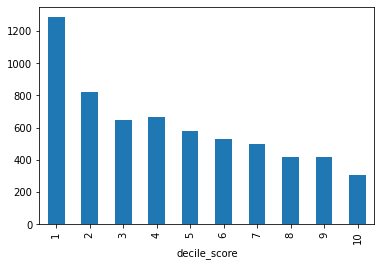

In [11]:
#number of people by COMPAS score, i.e. likelihood of recidivism

ds.groupby("decile_score")["decile_score"].count().plot.bar()

We see that generally, convicts are more likely to be given a lower `decile_score`.

In [12]:
# number of people by COMPAS risk category

ds.groupby("score_text")["score_text"].count()

score_text
High      1144
Low       3421
Medium    1607
Name: score_text, dtype: int64

Now that we have a general idea of what the dataset looks like, we will break down some of these statistics with respect to certain demographics. Namely, we will be looking at race, sex, and age group.


We will start by looking at the average COMPAS score (decile_score) with respect to these demographics

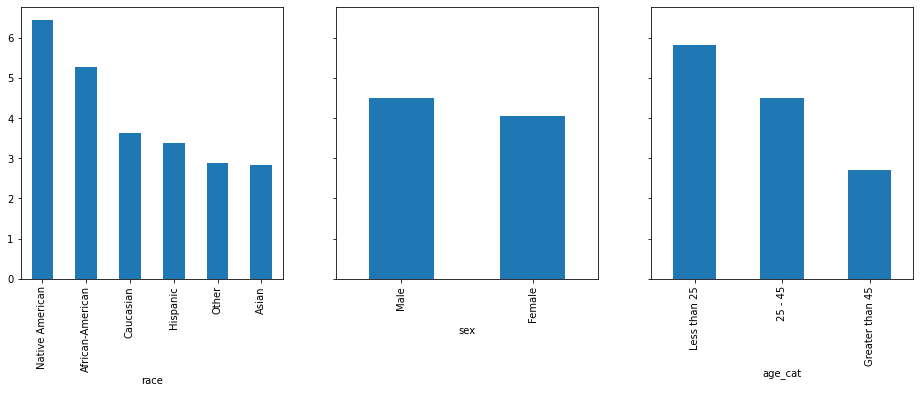

In [13]:
import matplotlib.pyplot as plt
#mean of COMPAS score by race

race_mean = ds.groupby("race")["decile_score"].mean()

race_mean = race_mean.sort_values(ascending=False)

#mean of COMPAS score by gender

gender_mean = ds.groupby("sex")["decile_score"].mean()

gender_mean = gender_mean.sort_values(ascending=False)

#mean of COMPAS score by age

age_mean = ds.groupby("age_cat")["decile_score"].mean()

age_mean = age_mean.sort_values(ascending=False)


#define a plot such that subplots can be placed side-by-side

fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(16,5))

race_mean.plot(kind='bar', x='LABEL',  legend=False, ax=axes[0])
gender_mean.plot(kind='bar', x='LABEL',ax=axes[1])
age_mean.plot(kind='bar', x='LABEL',ax=axes[2])
plt.show()





There are some noteworthy observations to make here. Firstly, Native Americans and African Americans have significantly higher average COMPAS scores than convicts belonging to other races. Secondly, younger age groups are also associated with higher average COMPAS scores. However, these disproportionalities do not necessarily imply unfairness.

To continue our analysis, we'll use look at the distribution of convicts with respect to COMPAS scores, by race:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff117ae4450>,
      dtype=object)

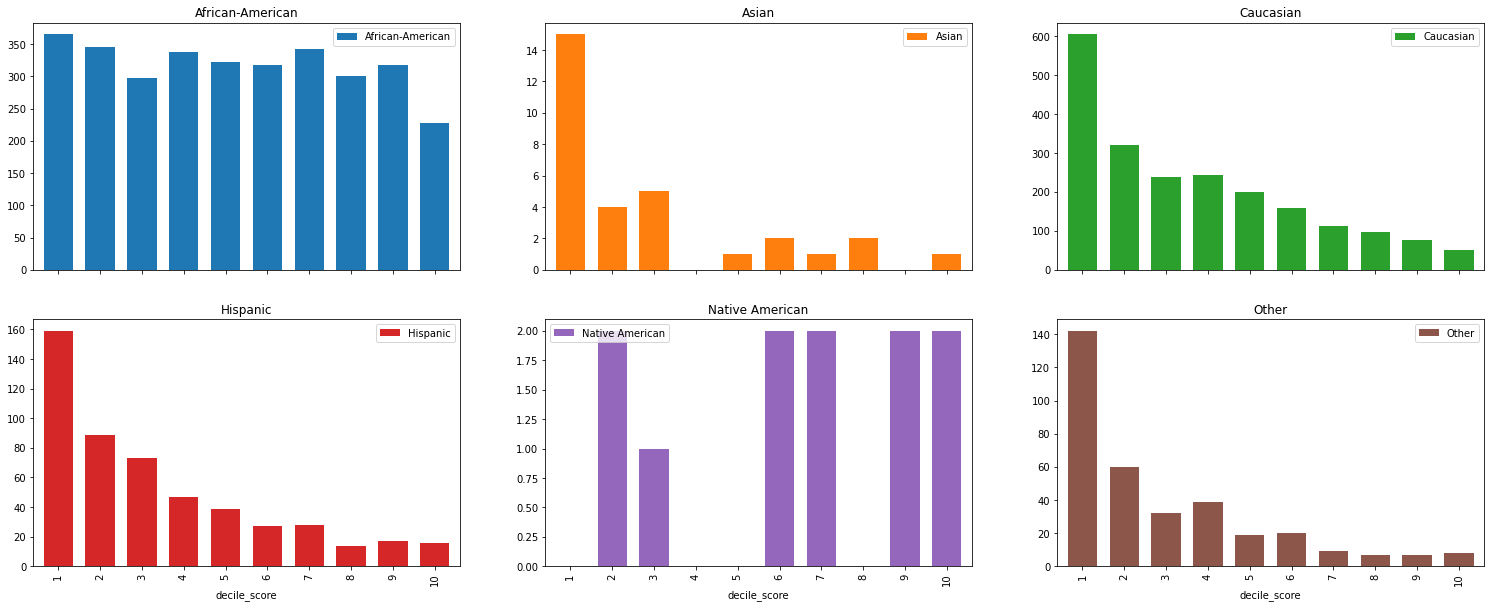

In [14]:
#history

q2=ds.groupby(["race","decile_score"])["decile_score"].count()
q2 =q2.unstack().fillna(0)
q2.transpose().plot.bar(figsize=(26,10), width=0.7, subplots=True, layout=(2,3))

The above histograms are also interesting. Most notably, African-Americans convicts are the only groups with a uniform distribution, while Caucasian, Hispanic, and Other convicts display a right-skewed distribution. This means that African-Americans are much more likely to recieve higher COMPAS scores, which at least partially explains the group's higher mean. Of course, this is no definitive proof that Equivant's assessment tool is biased, but it gives reason to analyze more deeply. 

Notice also the strange distributions of Asian and Native American convicts. This can most likely be attributed to the relatively small number of Asian and Native American convicts in the database. It is difficult to say whether this is because the groups represent a small proportion of the United States' population, or if it is because members of this group rarely commit crimes.

Now, we look at the gender distributions:

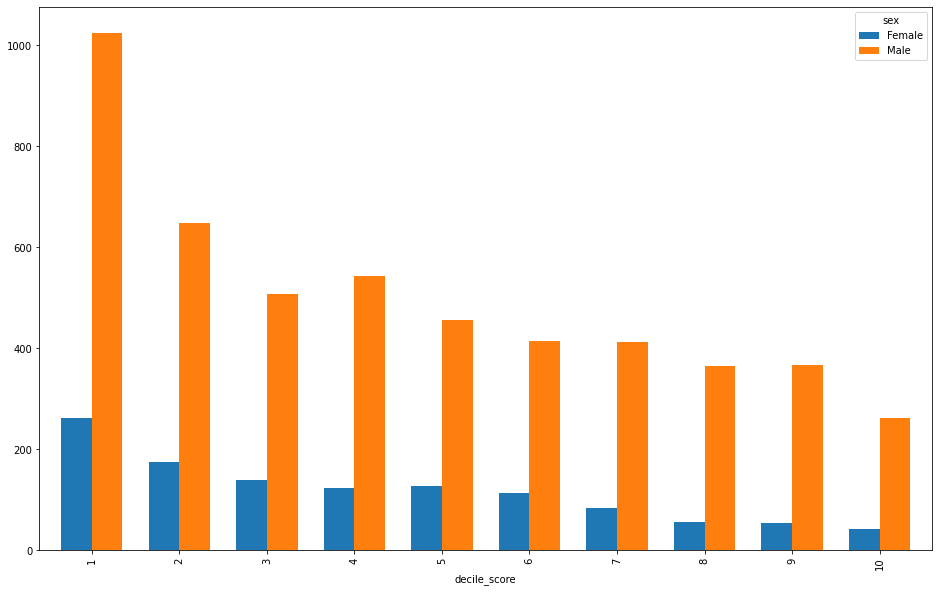

In [15]:


q = ds.groupby(["decile_score","sex"])["decile_score"].count()
q =q.unstack()


gender_ratio = q.Male / (q.Male + q.Female)

#print(a)

q.plot.bar(figsize=(16,10), width=0.7) 


Here, we see relatively similar distributions. To make sure, we also plotted the male/female ratio with respect to COMPAS score below:

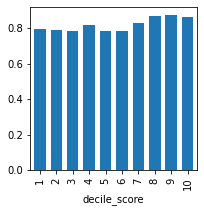

In [16]:
q = ds.groupby(["decile_score","sex"])["decile_score"].count()
q =q.unstack()

gender_ratio = q.Male / (q.Male + q.Female)
gender_ratio.plot.bar(figsize=(3,3), width=0.7)

We see that the ratios are effecively uniform throughout.

Finally, the age group distributions:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1171367d0>,
      dtype=object)

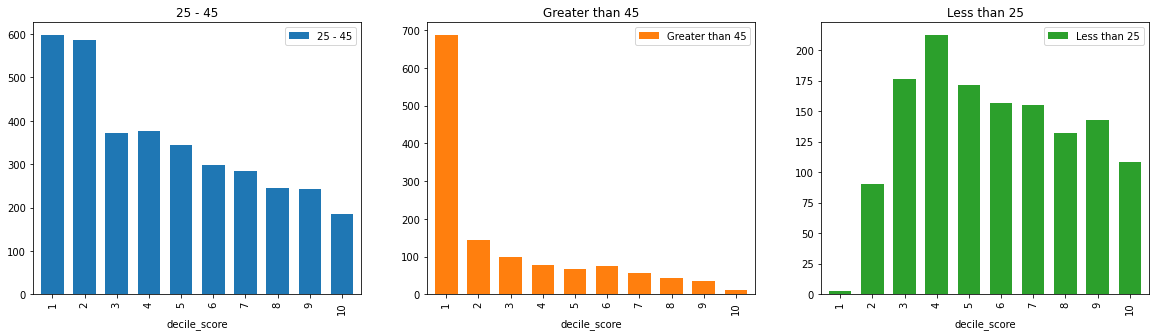

In [17]:
q = ds.groupby(["decile_score","age_cat"])["decile_score"].count()
q =q.unstack()


#gender_ratio = q.Male / (q.Male + q.Female)

#print(a)

q.plot.bar(figsize=(20,5), width=0.7, subplots=True, layout=(1,3)) # can we order this?


The findings above match the means: younger age groups have a higher mean. Here, we see that younger people are _much_ more likely to get higher COMPAS scores. As convicts get older, they are less likely to recieve high scores. Similar to the race histograms, determning whether there is bias requires further analysis.

### Performance Analysis

Now that we have taken a basic look at the demographics of the dataset, we will compute some basic performance metrics to get some insight on whether or not Equivant's COMPAS risk assessment tool is fair.

#### Interesting Preface

Below you will find the number of convicts who were arrested within two years of their release. Equivant's classifier aims to predict the risk of recidivism within 2 years. Thus, the following statistics is highly important, as it will be crucial in validating (or invalidating) Equivant's tool.

In [18]:
#number of rearrests
a = ds[ds.two_year_recid == 1]

b = a.two_year_recid.sum()

print("Total number of re-arrests : ",b)

Total number of re-arrests :  2809


The number above, on its own, is not so useful. We will now look at it in terms of race, gender, and age, again.

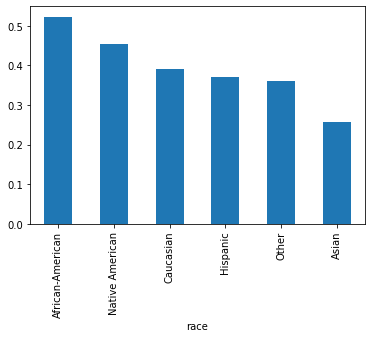

In [19]:
#compute rate of recidivism by race
ds.groupby("race")["two_year_recid"].mean().sort_values(ascending=False).plot.bar()


Above, we find that, specifically, African Americans have a higher rate of recidivism. This is what would be expected if the COMPAS tool is assumed to be accurate (which we are not yet willing to do), because - as we have seen in the previous graphs - it places a higher risk, on average, to African Americans than other races.

However, this is not a validation of the COMPAS classifier, as accuracy can often be a deceptive metric.

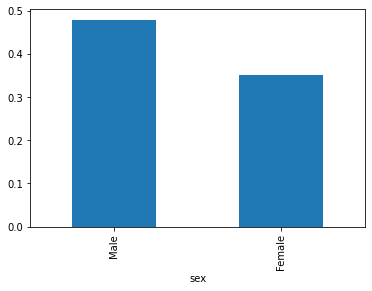

In [20]:
#compute rate of recidivism by gender
ds.groupby("sex")["two_year_recid"].mean().sort_values(ascending=False).plot.bar()

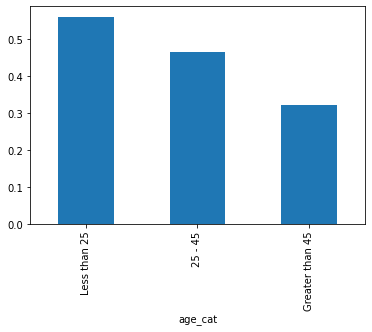

In [21]:
#compute rate of recidivism by age group
ds.groupby("age_cat")["two_year_recid"].mean().sort_values(ascending=False).plot.bar()

The same observations made about the rate of recidivism of races can be made for these age groups. 

#### Remark

Evaluating the performance of the COMPAS software is not trivial by any means. One difficulty is that Equivate's classifier is more of a score function; it gives convicts risk scores of 1 to 10. However, the _true_ label in this case, is binary: convicts either recidivate or they do not. Indeed, typically a threshold is defined with respect to such a score function, where scores under the threshold represents a negative prediction, and those over it a positive one. However, because the software functions as a recommendation system, the threshold is defined by the judicial figure in charge of sentencing a convict. And, because every judicial figure will have a different interpretation of the risk values, we have no way of definition such a threshold ourselves..

ProPublica chose a `decile_score` of 5 as the threshold, their [justification](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) being that "According to [Northpointe’s practitioners guide](http://www.equivant.com/wp-content/uploads/Practitioners-Guide-to-COMPAS-Core-040419.pdf), COMPAS 'scores in the medium and high range garner more interest from supervision agencies than low scores, as a low score would suggest there is little risk of general recidivism,'". However, Equivant has since then updated their [COMPAS practitioners guide](http://www.equivant.com/wp-content/uploads/Practitioners-Guide-to-COMPAS-Core-040419.pdf), and no longer make the claim (perhaps due to ProPublica's analysis of their classifier). Nevertheless, a threshold between 5 and 7 sounds reasonable as "Medium" risk score "represent cases that are veryclose to 'average' for the total population of the agency", according to Equivalent. However, out of rigor, we shall compute metrics with respect to more than one threshold.


#### Preliminary Calculations

To make the calculation of metrics simlper, we start out by defining some (slightly overengineered) functions. The first, `prelim_calc` computes the number of True Positives, True Negatives, False Positives, and False Negatives with respect to a given demographic `demo` and a threshold `threshold`:


In [22]:
def prelim_calc(demo, threshold, ds):
    

    # get all the recidivists

    recids = ds[ds.two_year_recid == 1]

    # get the non-recidivists

    non_recids = ds[ds.two_year_recid == 0]

    # get TP

    TP = recids[recids.decile_score >= threshold].groupby(demo).count().two_year_recid
    
    # get TN
    
    TN = non_recids[non_recids.decile_score < threshold].groupby(demo).count().two_year_recid

    # get TP

    FP = non_recids[non_recids.decile_score >= threshold].groupby(demo).count().two_year_recid
    
    # get FN

    FN = recids[recids.decile_score < threshold].groupby(demo).count().two_year_recid
    
    # return everything

    return TP, TN, FN, FP

TP, TN, FN, FP = prelim_calc('race', 2, ds)
#for i in range(2,10):
#    TP, TN, FN, FP = prelim_calc('race', i, ds)
#    print((TP + TN) / (TP + TN + FN + FP))

The second function plots a given metric `mode` with respect to a given demographic `demo` for all thresholds from 2 to 9. It even prints the thresholds at which the metric is at a maximum and minimum.

In [23]:
#maybe change thisso that it only shows the graph + a graph of averages

def plot_thresholds(height, width,demo, mode, ds):
    colors = plt.rcParams["axes.prop_cycle"]()

    plt.rcParams.update({'font.size': 18})
    
    start = 2

    fig, axs = plt.subplots(height,width, figsize=(16,16), sharey=True)

    max_mean = 0
    min_mean = 1
    min_thresh = start
    max_thresh = 9
    for threshold in range(start,10):
        c = next(colors)["color"]
        i = threshold - start
        x = i % width
        y = (int) (i / width)

        fig.tight_layout()
        TP, TN, FN, FP = prelim_calc(demo, threshold, ds)
        
        
        if (mode == 'acc'):
            metric = (TP + TN) / (TP + TN + FP + FN)
            
        elif (mode == 'FPR'):
            metric = FP / (FP + TN)
            
        elif (mode == 'FNR'):
            metric = FN / (FN + TP)
        elif (mode == 'prec'):
            metric = TP / (TP + FP)
        elif (mode == 'rec'):
            metric = TP / (TP + FN)
        else:
            print("Error, metric not recognized.")
            return
            

        if (metric.mean() > max_mean):
            max_mean = metric.mean()
            max_thresh = threshold
            
        if (metric.mean() < min_mean):
            min_mean = metric.mean()
            min_thresh = threshold

        
        axs[y][x].title.set_text( mode + ", threshold = " + str(threshold))
        plt.yticks(np.arange(0, 1, .05))

        metric.plot.bar(ax=axs[y][x], color = c)
        
    print("Maximum mean of " + mode + " by " + demo + " is obtained when threshold = " + str(max_thresh))
    print("Minimum mean of " + mode + " by " + demo + " is obtained when threshold = " + str(min_thresh))


We will also remove Asian and Native American convicts, as they represent a very small portion of the dataset, and it is therefore very difficult to make any observations with any reasonable degree of confidence.

In [24]:
def rem_asian_na(ds):
    ds = ds[ds.race != 'Asian']
    ds = ds[ds.race != 'Native American']
    return ds

ds = rem_asian_na(ds)

Now, we have everything we need to compute our metrics.

**Important note**: The following graphical representations of the metrics was very inefficiently done. Indeed, we later realized that we would have been better off plotting line graphs for the accuracy and ROC curves for the rest, but we had a weaker understanding of the material at the time of writing this.

#### Accuracy

We will now use several metrics in order to measure the performance of the COMPAS classifier. The first metric calculated will be the **accuracy**, which is a general measure of, in this case, how often the classifier correctly predicted that a convict _did_ or _did not_ recidivate. We use the function defined above to get a better get our accuracies:

Maximum mean of acc by race is obtained when threshold = 6
Minimum mean of acc by race is obtained when threshold = 2


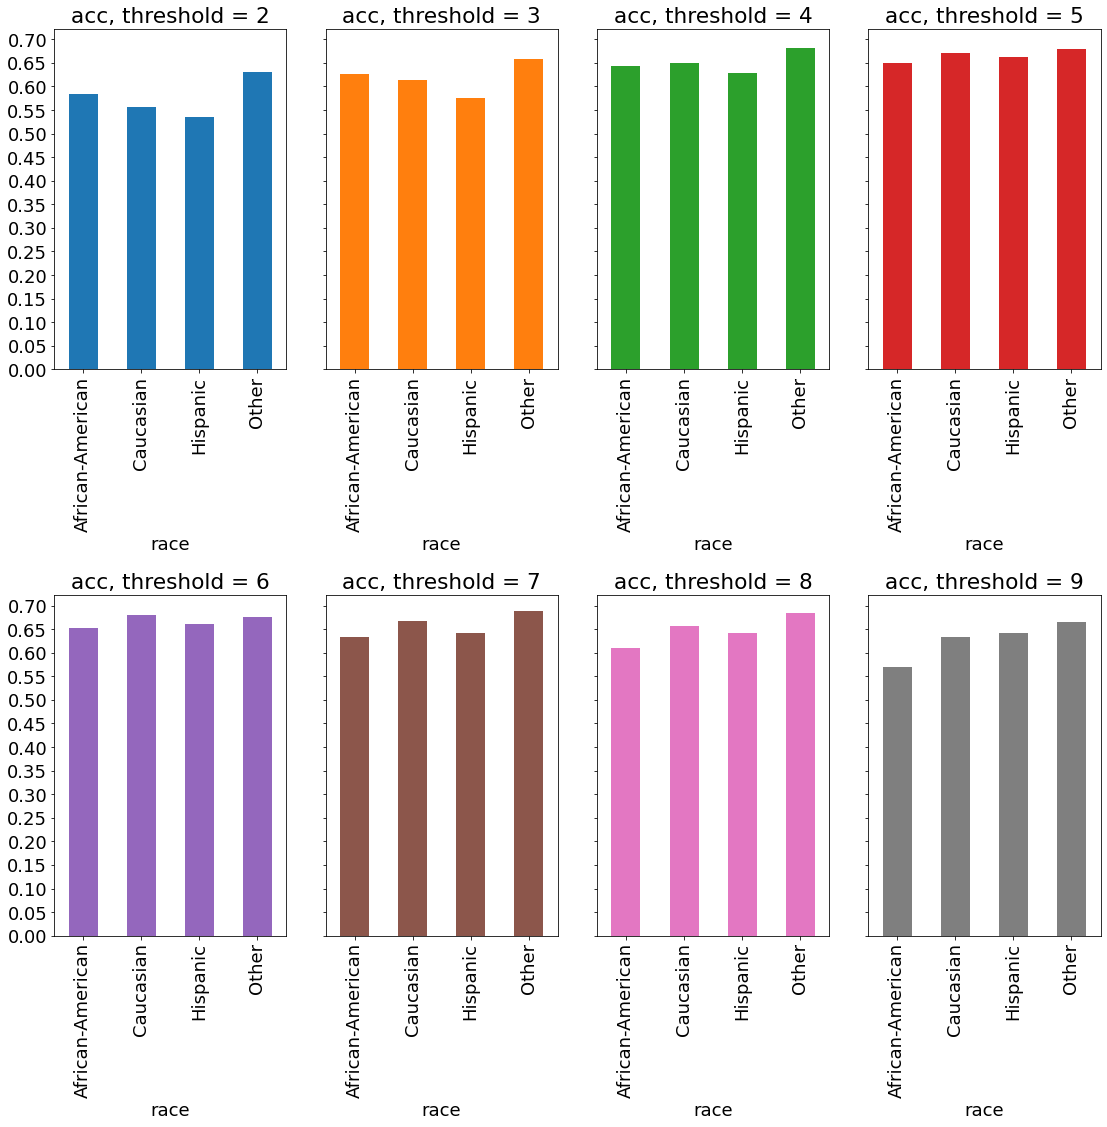

In [25]:
plot_thresholds(2,4, 'race', 'acc', ds)

The first thing we notice is that the races have near-equivalent accuracies, and that these accuracies are _reasonably_ high (for a recommendation tool). However, the accuracy is a relatively basic metric; it tends not to show bias very well. This is especially true for unbalanced datasets, which the COMPAS dataset evidently is (based on our preliminary analysis).

In the 'Loan Granting' case study from the 'Fairness in Machine Learning' lecture, we have a perfect example of an algorithm that is clearly biased, as it is only trying to maximize profits without ensuring fairness. This results in having a respectable accuracy. However, further inspection reveals that certain groups may be victims of higher false negative and positive rates. The same may be the case for the COMPAS classifier. Thus, accuracy may not be enough.

Indeed, because accuracy is concerned with true positives and true negatives, it implicitly gives the same weight to false positives and false negatives. In this context, this is wrong. We will develop more on this later.

In conclusion, looking at the diffierent accuracies based on the threshold used, we find that the per-race accuracies are essentially equivalent. Again, this does not validate the classifier, for reasons explained later.

Maximum mean of acc by sex is obtained when threshold = 6
Minimum mean of acc by sex is obtained when threshold = 2


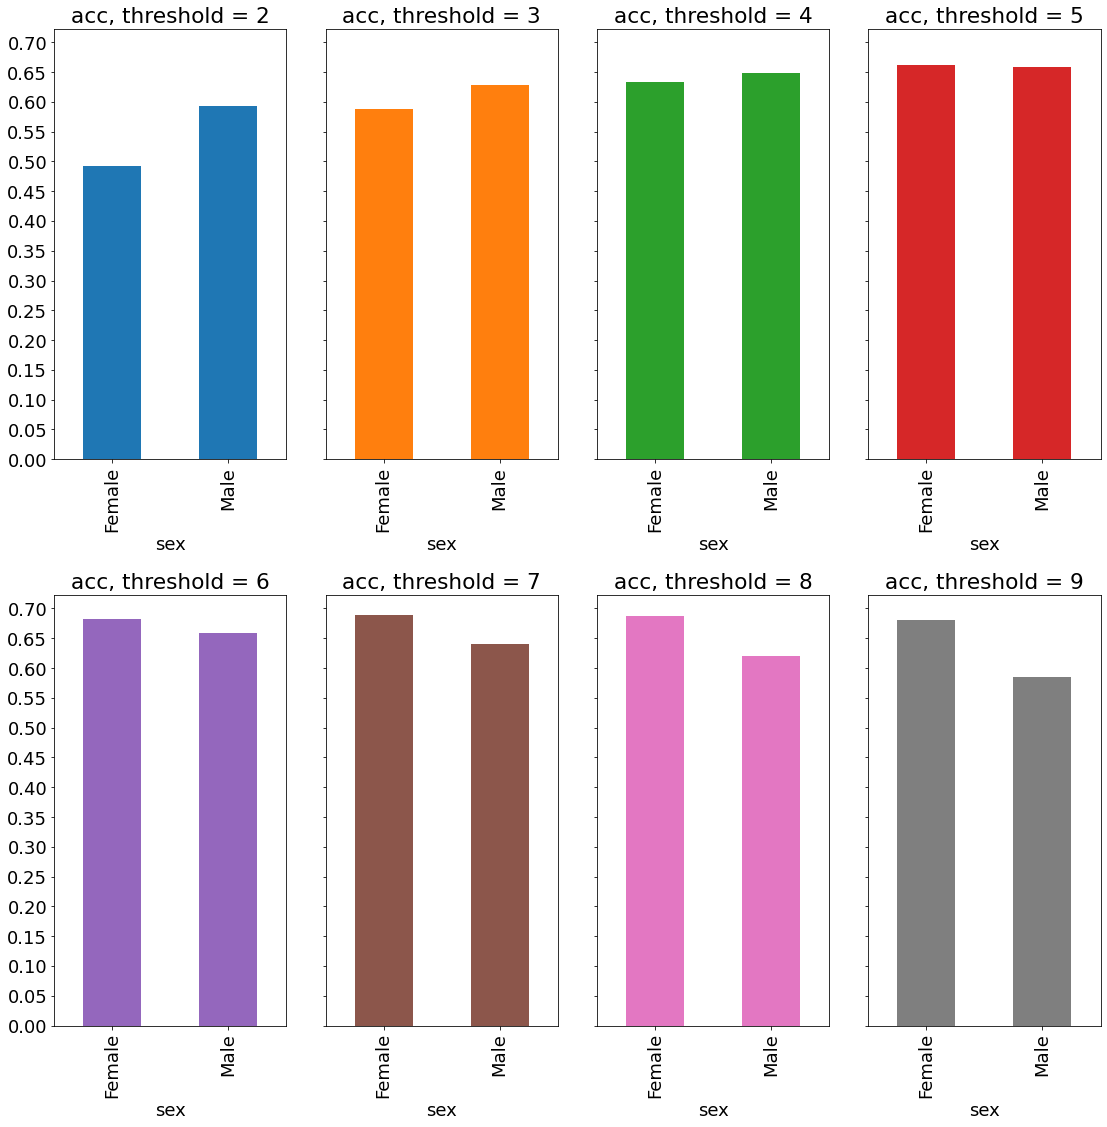

In [26]:
#removing Asian and Native American convicts

plot_thresholds(2, 4, 'sex', 'acc',ds) 

Maximum mean of acc by age_cat is obtained when threshold = 6
Minimum mean of acc by age_cat is obtained when threshold = 2


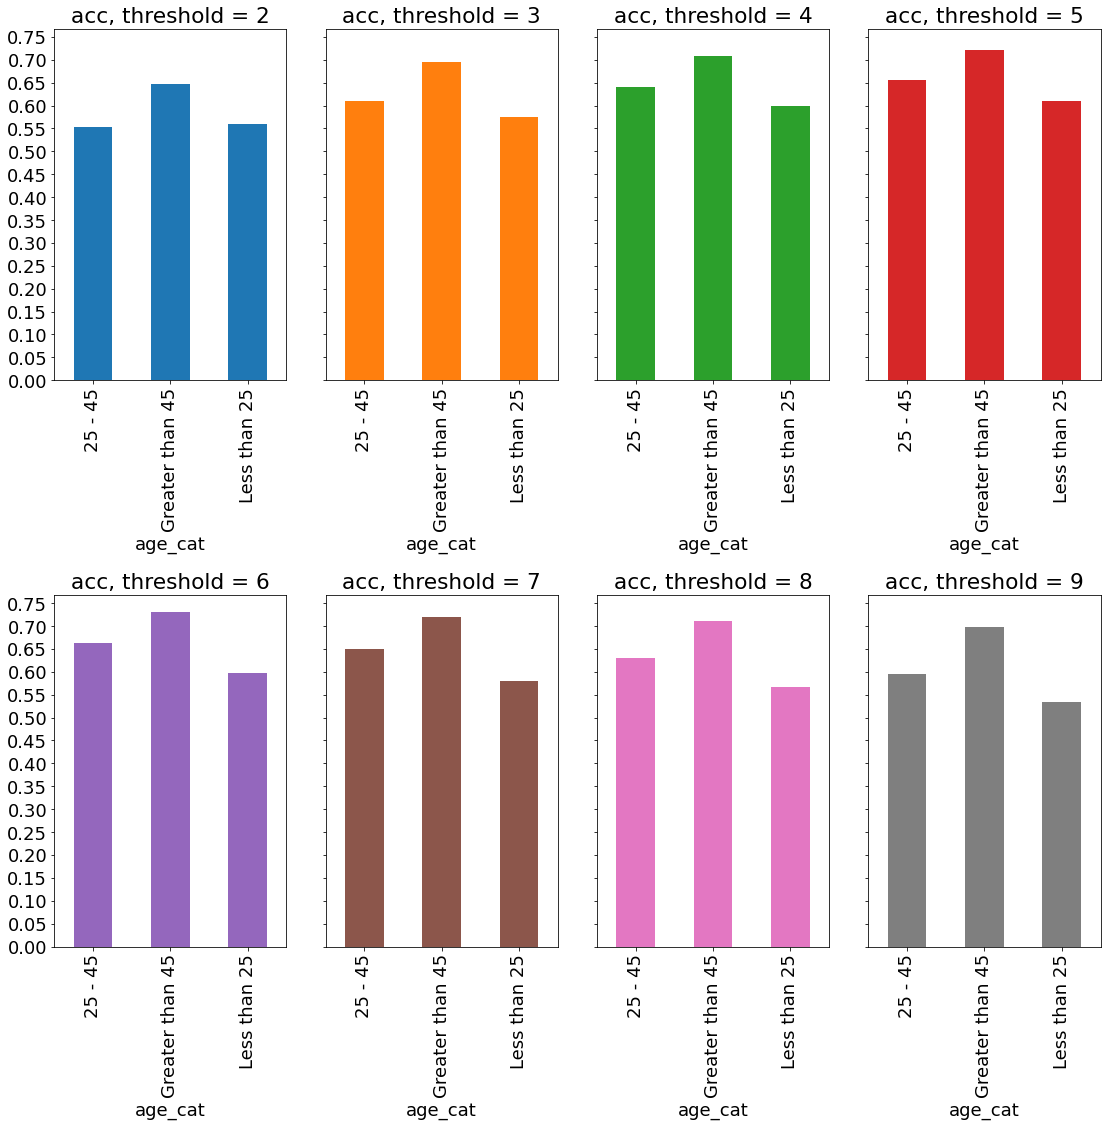

In [27]:
plot_thresholds(2, 4, 'age_cat', 'acc',ds)

Similar remarks can be made about the gender and age group accuracies.

### False Positive Rates and False Negative Rates

Now that we have made it clear that the accuracy is not enough to judge fairness, we will look into other metrics. The false positive rate (**FPR**) and false negative rate (**FNR**) metrics allow us to look as how often a prediction of "false" turns out to be a "true" and vice versa, respectively. A high FPR, in this context, signifies that many people who were labelled "high risk" end up not recidivating. Alternatively, a high FNR means that many convicts who are labelled as "low risk" end up getting arrested again. Here, we see the potential problem with accuracy: even if the classifier lables a high percentage of any race correctly, it says nothing about the FPR and the FNR within those classes.

Finally, we can look into the false positive and false negative rates of the COMPAS classifier to get a closer look into its performance:

Maximum mean of FPR by race is obtained when threshold = 2
Minimum mean of FPR by race is obtained when threshold = 9


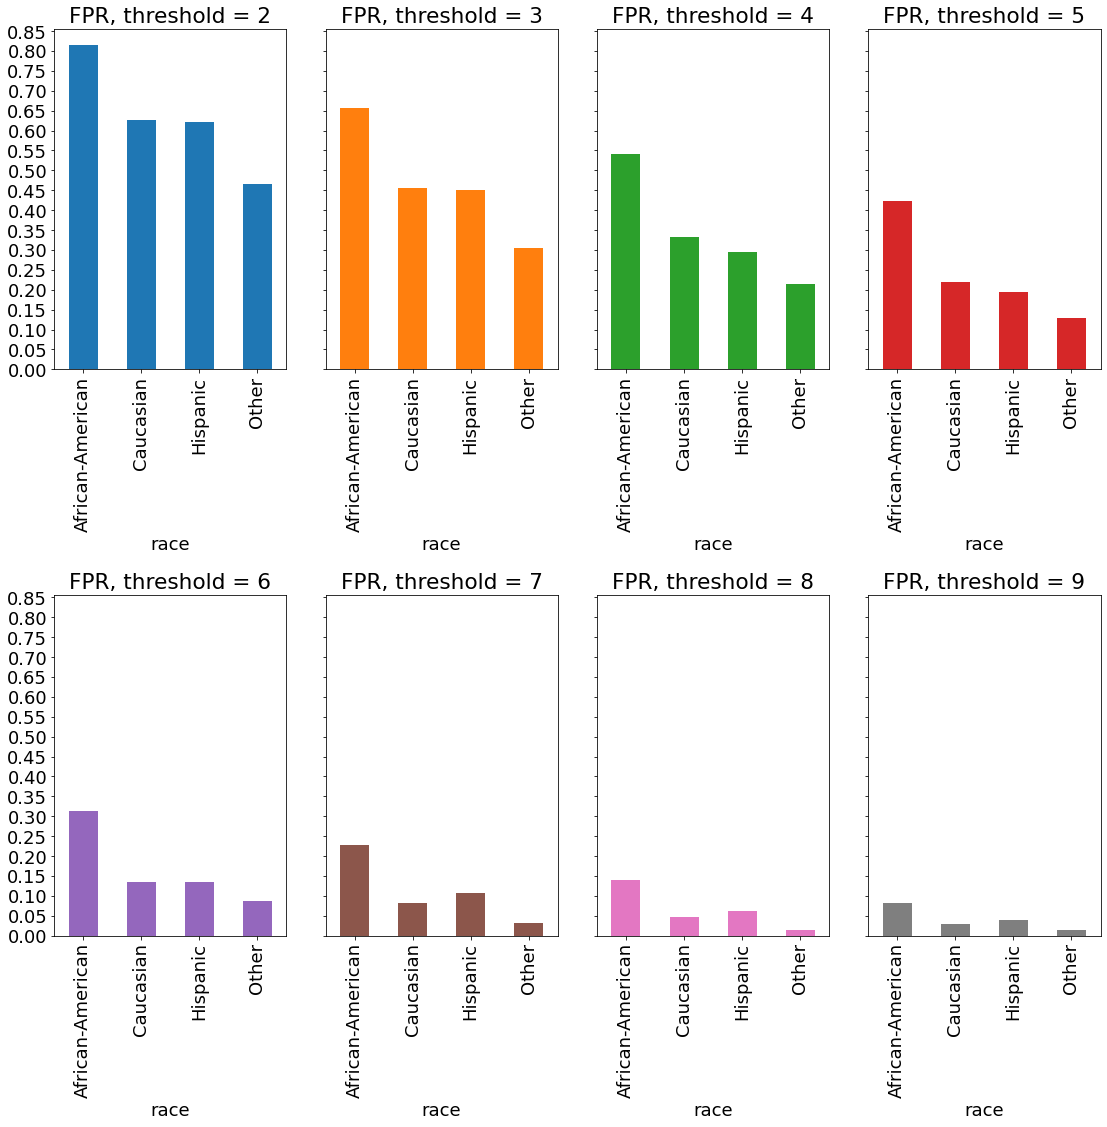

In [28]:
plot_thresholds(2, 4, 'race', 'FPR',ds)

Maximum mean of FNR by race is obtained when threshold = 9
Minimum mean of FNR by race is obtained when threshold = 2


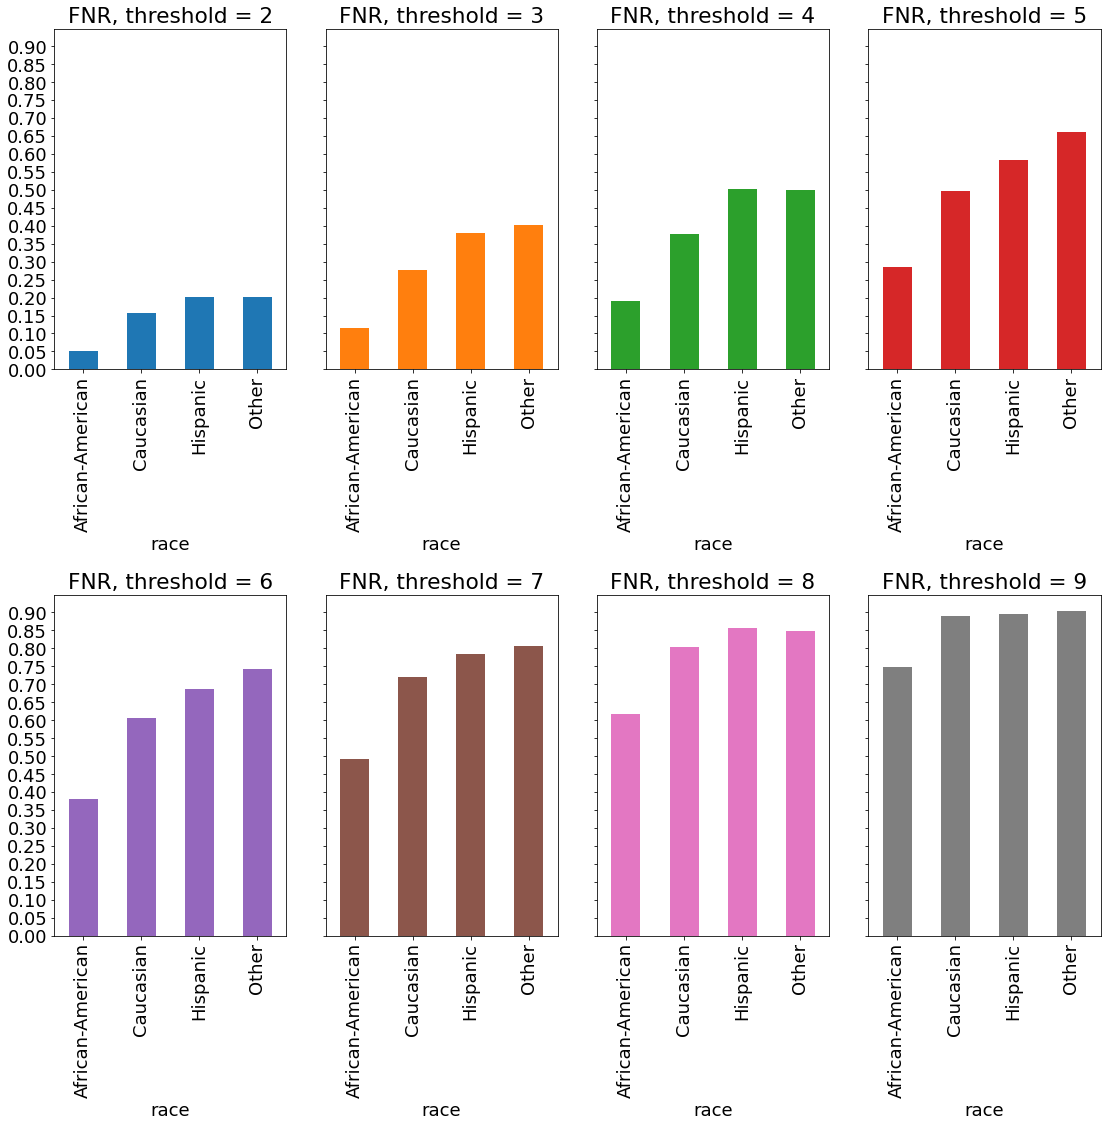

In [29]:
plot_thresholds(2, 4, 'race', 'FNR',ds)

Looking at the FPR, we see that no matter the threshold, African Americans have a significantly higher rate than all other races. For the FNR, we get the inverse: African Americans have a significantly lower rate than the other groups.

It was important that we plotted the data for each threshold, as we wanted to make sure that there did not exist a threshold for which there was a bias. Here, we see that the bias exists for every threshold. In fact, the ratio of the rates between races is preserved throughout the different threshold values - which is unexpected. We think this may indicate that the bias is inherent to the data.

It is also important to take into consideration what these statistics imply. African American convicts, because of their higher FPR, are more likely to be labelled high-risk when they are not. Furthermore, African American convicts, because of their lower FNR, are less likely to be labelled low-risk when they are not. To be clear, having a low FNR is a good thing, but it is not fair for a certain demographic to have a higher FNR than others. Therefore, the COMPAS classifier is **biased against African Americans**.

Bar graphs give us a good view of the rates relative to other races. However, we would now like to get a look at the precise values. Also, now that we know that the ratio "transcend" the threshold, we will look at thresholds of 5, as this seems to be the threshold where we can maximize both FPR and FNR. 



In [30]:
# plots / displays for only one given threshold

def plot_one_thresh(demo, mode, ds, threshold, pl= True, pr = True):
   
    plt.rcParams.update({'font.size': 18})

    fig.tight_layout()
    TP, TN, FN, FP = prelim_calc(demo, threshold, ds)  
        
    if (mode == 'acc'):
        metric = (TP + TN) / (TP + TN + FP + FN)
            
    elif (mode == 'FPR'):
        metric = FP / (FP + TN)
            
    elif (mode == 'FNR'):
        metric = FN / (FN + TP)
        
    elif (mode == 'prec'):
        metric = TP / (TP + FP)
        
    elif (mode == 'rec'):
        metric = TP / (TP + FN)
        
    else:
        print("Error, metric not recognized.")
        return
            
    
    if (pr):
        display(metric)
        
    if (pl):
        plt.yticks(np.arange(0, 1, .05))
        metric.plot.bar()


In [31]:
plot_one_thresh('race', 'FPR', ds, 5, False, True)
plot_one_thresh('race', 'FNR', ds, 5, False, True)

race
African-American    0.423382
Caucasian           0.220141
Hispanic            0.193750
Other               0.127854
Name: two_year_recid, dtype: float64

race
African-American    0.284768
Caucasian           0.496350
Hispanic            0.582011
Other               0.661290
Name: two_year_recid, dtype: float64

The FPR and FNR seem to complement each other; for any race, they add up to be about 60. Indeed, this explains why the accuracies are so uniform between races, despite the bias. 

After some testing, we found that the ratio is also preservered throughout threshold values for gender and age category, so we will only be looking at those with one threshold as well. If you would like to see if for yourself, simply uncomment the first line of the following cells.

sex
Female    0.302234
Male      0.304314
Name: two_year_recid, dtype: float64

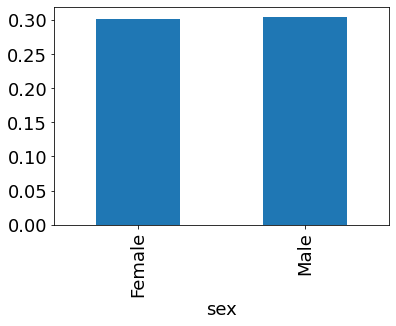

In [32]:
#plot_thresholds(2, 4, 'sex', 'FPR',ds)
plot_one_thresh('sex', 'FPR', ds, 5, True, True)

sex
Female    0.404878
Male      0.380134
Name: two_year_recid, dtype: float64

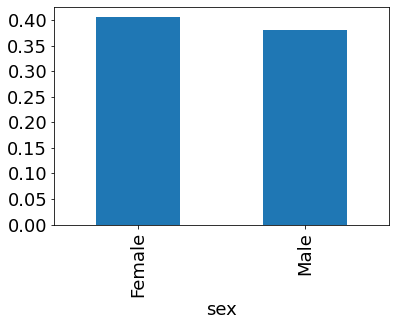

In [33]:
#plot_thresholds(2, 4, 'sex', 'FNR',ds)
plot_one_thresh('sex', 'FNR', ds, 5, True, True)

Indeed, we see no effective disrepency between men and women. Because of this, we think it is likely that there is no bias between sexes. Hence, we will stop looking at the gender demographic for now.

age_cat
25 - 45            0.310198
Greater than 45    0.131881
Less than 25       0.538200
Name: two_year_recid, dtype: float64

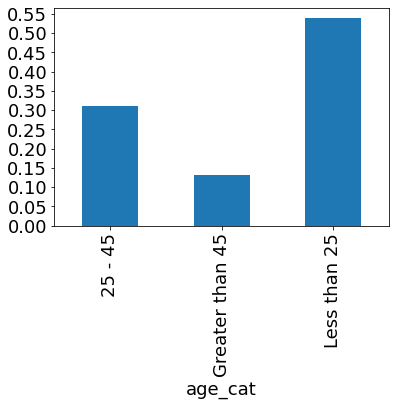

In [34]:
#plot_thresholds(2, 4, 'sex', 'FPR',ds)
plot_one_thresh('age_cat', 'FPR', ds, 5, True, True)

age_cat
25 - 45            0.382173
Greater than 45    0.593137
Less than 25       0.273333
Name: two_year_recid, dtype: float64

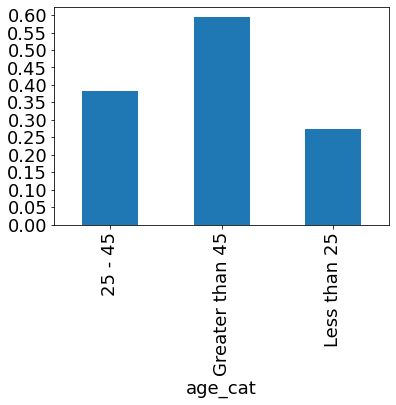

In [35]:
#plot_thresholds(2, 4, 'sex', 'FPR',ds)
plot_one_thresh('age_cat', 'FNR', ds, 5, True, True)

Interestingly, we also find a bias among age categories; younger convicts tend to have a higher FPR and a lower FNR than their older counterparts, similarly to African American convicts. Thus, we can also say that the COMPAS classifier is **biased against younger convicts**.

In [36]:
#looking at rate of recidivism by race

total = ds[ds.two_year_recid == 1].groupby('race').count().two_year_recid
size = ds.groupby('race')['race'].count()


display(total/size)

race
African-American    0.523150
Caucasian           0.390870
Hispanic            0.371316
Other               0.361516
dtype: float64

## Standard Classifiers

We will now compare several kinds of classifiers on the dataset, and compare their performances with the COMPAS classifier. Machine learning algorithms can be very sensitive, and it can sometimes be difficult to discern why certain algorithms are more effective than others. Nevertheless, out of a range of different kinds of classifiers, we aim to find which types of classifiers would best-serve this dataset.

We will begin by scatterplotting our data, in order to get a better idea of its distribution and separability.

### Scatterplotting Data

Of course, because each feature represents a dimension, and a scatterplot is a 2D/3D visualization, the first step is to use a *dimensionality reduction* technique. There are a few well-known methods for achieving this: PCA, autoencoders, T-SNE, etc. Naturally, there are benefits and drawbacks to any of these methods. The T-SNE algorithm is well-known for being one of the more powerful dimensionality reduction techniques, especially when there is a low number of dimensions (<30). More specifically, it is known to handle non-linear datasets better than its counterparts. However, it is also very sensitive to hyperparameter changes (perplexity, number of iterations, etc.), it is non-deterministic (so it may require several runs to get something that "looks right"), and - perhaps most importantly - it does not preserve cluster sizes and distances between clusters. Thus, because the point of the scatterplot visualization is to get a better idea of the distribution and separability of our data such that we can find out what classifiers may best-suit it, we will instead be using PCA. Despite the fact that PCA can be inaccurate when it comes to non-linear datasets (which we suspect our dataset to be), it is practical and easy-to-use, so it seems like the right option here.

Before plotting, we must choose our features.

#### Feature Choice

[Equivalen't Practitioners Guide](https://www.equivant.com/wp-content/uploads/Practitioners-Guide-to-COMPAS-Core-040419.pdf) states that "criminal  involvement  (prior  arrests  and  prior  sentences  to  jail, prison, and  probation),  vocational/educational  problems,  drug  history,  age-at-assessment,and age-at-first-arres" are all predictors of recidivism. This seems logical; convicts with priors, specifically those who have engaged in a life of crime from an early age, are probably likely to recidivate. Hence, we will be using *juv_fel_count, juv_misd_count, priors_count, c_charge_deg* as our features. 

Furthermore, there is a question as to whether certain demographic features should be added. Namely, should sex, age, or race be included in the input? The ultimate decision was to leave sex and race out, as adding them would seem to be inviting unfairness: the addition of such demographic features would have the implication that belonging to a given demographic has an intrinistic influence on the likelihood for one to recidivate. In reality, the scientific concensus is that the reasons a given gender or race might be responsible for a disproportionate amount of crime is due to **sociological reasons** (gender norms, socioeconomic status, living in urban areas, etc.). Nevertheless, we do not expect that leaving out race as a feature will do anything to solve the bias that tends to occur in these classifiers.However, we have decided to use age as one of our features. Younger people are more prone to peer pressure, are less financially independent, etc., which in turn are predictors of crime. These traits *seem* intrinsic to one's youth, and so we will use age as a feature. [This article](https://open.lib.umn.edu/socialproblems/chapter/8-3-who-commits-crime/) gives a broad overview of why certain demographics commit more crime. 



In [37]:
features = ['juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree' , 'age']

#### Preprocessing 

Now, we need to encode some of the data, as the classifier won't accept strings as inputs. Luckily, sklearn has a LabelEncoder() function that does just that:

In [38]:
from sklearn import preprocessing
ds = reset()
ds = clean_data(ds)


def encode_feature(ds, feature):
    l = ds[feature].unique()
    le = preprocessing.LabelEncoder()
    le.fit(l)
    return le

def encode_all(ds, features):
    ret = []
    for feature in features:
        le = encode_feature(ds, feature)
        array = le.transform(ds[feature].values)
        ret.append(array.tolist())
    return ret, le

def restructure(X):
    res = []
    for i in range(0, len(X[0])):
        B = []
        for j in range(0, len(X)):
            
            e = X[j][i]
            B.append(e)
        res.append(B)
    return res




#### Plotting

Now that the data has been encoded, we define some functions. You may notice that we've also defined a function which uses sklearn's Kernel-PCA function.

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

Dataset = ds[features]
Results = ds['two_year_recid']
X, le = encode_all(Dataset, features)
X = restructure(X)
y = ds['two_year_recid'].values


def pcak(data, kernel, pc_count = None):
    return KernelPCA(n_components = 2, kernel = kernel).fit_transform(data)

def scatterplot(data):
    a = []
    b = []
    colors = []
    counter = 0
    for i in data:
        a.append(i[0])
        b.append(i[1])

        recid = ds.two_year_recid.values[counter]

        if (recid):
            colors.append('red')
        else:
            colors.append('blue')
        counter += 1

    plt.scatter(a,b, c = colors)
    plt.show()


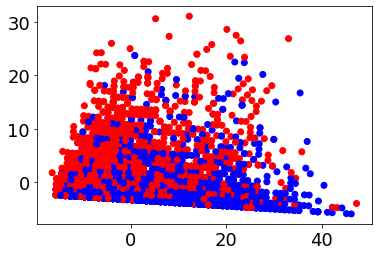

In [40]:
X = pcak(X, 'linear')
scatterplot(X)

The scatterplot has an interesting structure. It seems as though the greater the y-value, the higher the density of recidivists. The lower half seems to have a high mixture of both labels, but it seems the dataset may still be **rougly** linearly separable, but could benefit from using more flexible (i.e. non-linear) classifiers. Thus, we think that Quadratic Discriminant Analysis (QDA), Random Forest, and a simple neural network would work best. A QDA seems like a more flexible RBF SVM  (in terms of results, not algorithmic approach). Meanwhile, Random Forest classifiers are similar to Decision Trees in that they work well with discrete, non-continuous, correlated data, but do not fall victim to overfitting as much. Finally, neural networks are simply very powerful and flexible. If our hypotheses are correct, the result would most likely be relatively high accuracies. Ideally, we would like to be able to choose classifiers that would minimize unfairness, but this seems difficult at this stage. We could always try most classifiers and compute their metrics, but we prefer avoiding this brute-force technique.



Indeed, we see that the Random Forest and neural network do work relatively well. Although, even if the QDA classifier has a respectable accuracy, it seems that the RBF SMV has outperformed it, so we will be using that instead. Again, these accuracies are all quite close, so we think that they would all work relatively well. However, as we have learned, these accuracies say nothing about the potential bias of a classifier, so this will need looking into.

Now, we will train RBF SVM, the Random Forests, and the MLP algorithms to our dataset and compare their performances to the original COMPAS classifier.


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def encodeRace(str):
    races = ["African-American","Asian","Caucasian","Hispanic","Native American","Other"]
    return races.index(str)

def encodeSex(str):
    if(str == "Female"):
        return 0
    else:
        return 1

def encodeScore(str):
    scores = ["High","Low","Medium"]
    return scores.index(str)

def encodeAge(str):
    age_cats = ["25 - 45","Greater than 45","Less than 25"]
    return age_cats.index(str)

def encodeCharge(str):
    if(str == "F"):
        return 0
    else :
        return 1

def encodeElement(element,features):
    if 'c_charge_degree' in features:
        i = features.index('c_charge_degree')
        element[i] = encodeCharge(element[i])
        
    if 'race'in features:
        i = features.index('race')
        element[i] = encodeRace(element[i])
        
    if 'age_cat'in features:
        i = features.index('age_cat')
        element[i] = encodeAge(element[i])
        
    if 'score_text'in features:
        i = features.index('score_text')
        element[i] = encodeScore(element[i])
        
    if 'sex'in features:
        i = features.index('sex')
        element[i] = encodeSex(element[i])  
        
    return element
    
def encodeDataset(X,features):
    n = len(X)
    for i in range(n):
        X[i] = encodeElement(X[i],features)
    return X


ds = pd.read_csv(COMPAS_INPUT_FILE)
ds = clean_data(ds)

features_to_keep = ['juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree' , 'age','age_cat', 'two_year_recid','race','sex','decile_score', 'score_text']

ds = ds[features_to_keep]
ds = ds.dropna(axis=0)

# modify the features that we us for the classifier here

features_for_class = ['juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree' , 'age','age_cat']

Dataset = ds[features_for_class]
Results = ds['two_year_recid']

X_plus = encodeDataset(ds.values,features_to_keep) # the dataset but we kept the races and all to analyse
X = encodeDataset(Dataset.values,features_for_class)
y = Results.values



In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [43]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,test_size=0.1,random_state=1)
garbage3, X_plus_test, garbage1, garbage2 = train_test_split(X_plus, y,test_size=0.1,random_state=1)

#model = MLPClassifier(solver="lbfgs",activation="identity")

# Random Forest
randomForest = RandomForestClassifier(n_estimators=100)
randomForest.fit(Xtrain, ytrain)
predictedRF = randomForest.predict(Xtest)
probasRF = randomForest.predict_proba(Xtest)
    
# RBF SVM
RBF = SVC(gamma=2, C=1)
RBF.fit(Xtrain, ytrain)
predictedRBF = RBF.predict(Xtest)

# Neural Network

NN = MLPClassifier(solver="lbfgs",activation="identity")
NN.fit(Xtrain, ytrain)
predictedNN = NN.predict(Xtest)
probasNN = NN.predict_proba(Xtest)


In [44]:
def print_per_race(features,predict,X,y):
    races = ["African-American","Asian","Caucasian","Hispanic","Native American","Other"]
    races_used = ["African-American","Caucasian","Hispanic"]
    numbers = np.zeros((6,4))
    
    for i in range(len(predict)):
        race = races[X[i][features.index('race')]]
        if race in races_used :
            index = races_used.index(races[X[i][features.index('race')]]) # that's where the race is
            if(predict[i]==0 and y[i]==0): #TN
                         numbers[index][0] = numbers[index][0] + 1
            if(predict[i]==1 and y[i]==1): #TP
                         numbers[index][3] = numbers[index][3] + 1
            if(predict[i]==0 and y[i]==1): #FN
                         numbers[index][2] = numbers[index][2] + 1
            if(predict[i]==1 and y[i]==0): #FP
                         numbers[index][1] = numbers[index][1] + 1
    print(races)
    TPR = []
    FNR = []
    FPR = []
    TNR = []
    for i in range(len(races_used)):
        TPR.append(numbers[i][3] /(numbers[i][3]+numbers[i][2]))
        FNR.append(numbers[i][2] /(numbers[i][3]+numbers[i][2]))
        FPR.append(numbers[i][1] /(numbers[i][1]+numbers[i][0]))
        TNR.append(numbers[i][0] /(numbers[i][1]+numbers[i][0]))
    #print("TPR =",TPR)
    #plt.figure()
    #plt.title('TPR')
    #plt.bar(races_used,TPR)
    #plt.xticks(rotation=90)
    #print("FNR =",FNR)
    plt.figure()
    plt.title('FNR')
    plt.bar(races_used,FNR)
    plt.xticks(rotation=90)
    #print("FPR =",FPR)
    plt.figure()
    plt.title('FPR')
    plt.bar(races_used,FPR)
    plt.xticks(rotation=90)
    #print("TNR =",TNR)
    #plt.figure()
    #plt.title('TNR')
    #plt.bar(races_used,TNR)
    #plt.xticks(rotation=90)

Random forest

Accuracy: 0.6343
Precision: 0.6461
Recall: 0.5286
['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']


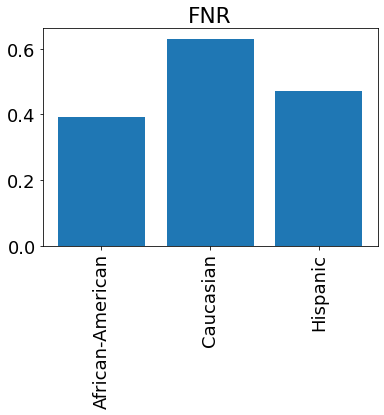

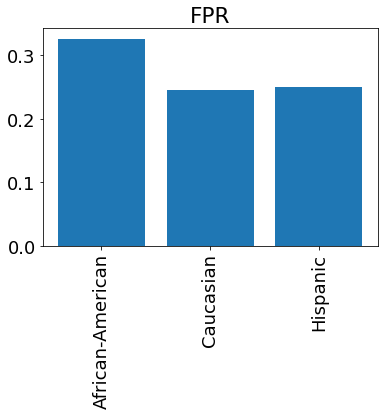

In [45]:
acc = accuracy_score(ytest, predictedRF)
precisionRF = precision_score(ytest, predictedRF)
recallRF = recall_score(ytest, predictedRF)
fmeasureRF = f1_score(ytest, predictedRF)
fprRF, tprRF, thresholdsRF = roc_curve(ytest, predictedRF)
rocRF = metrics.auc(fprRF, tprRF)
print("Accuracy: %0.4f" % acc)
print("Precision: %0.4f" % precisionRF)
print("Recall: %0.4f" % recallRF)
#print("F-mesure: %0.4f" % fmeasureRF)
#print("Surface sous la courbe ROC: %0.4f" % rocRF)
#skplt.metrics.plot_confusion_matrix(ytest, predictedRF, normalize=True)
#skplt.metrics.plot_roc(ytest, probasRF)
#skplt.metrics.plot_precision_recall(ytest, probasRF)
print_per_race(features_to_keep,predictedRF,X_plus_test,ytest)

RBF SVM

Accuracy: 0.6424
Precision: 0.6473
Recall: 0.5623
['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']


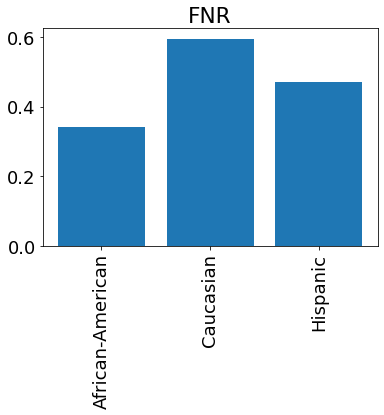

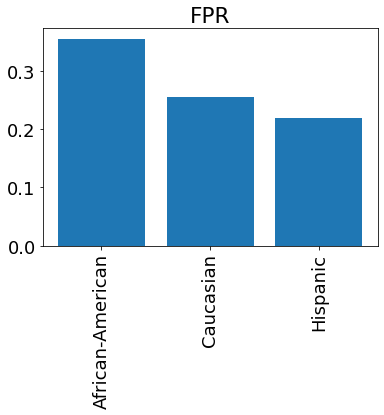

In [46]:
acc = accuracy_score(ytest, predictedRBF)
precisionRBF = precision_score(ytest, predictedRBF)
recallRBF = recall_score(ytest, predictedRBF)
fmeasureRBF = f1_score(ytest, predictedRBF)
fprRBF, tprRBF, thresholdsRBF = roc_curve(ytest, predictedRBF)
rocRBF = metrics.roc_auc_score(ytest, predictedRBF)
print("Accuracy: %0.4f" % acc)
print("Precision: %0.4f" % precisionRBF)
print("Recall: %0.4f" % recallRBF)
#skplt.metrics.plot_confusion_matrix(ytest, predictedRBF, normalize=True)
print_per_race(features_to_keep,predictedRBF,X_plus_test,ytest)

Neural Network

Accuracy: 0.6392
Precision: 0.6568
Recall: 0.5219
['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']


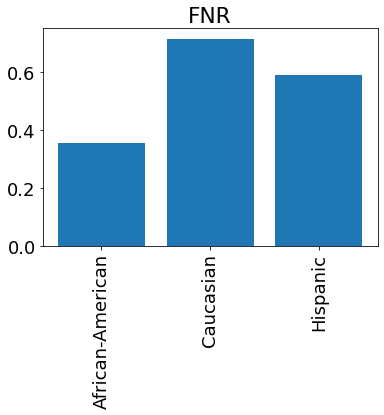

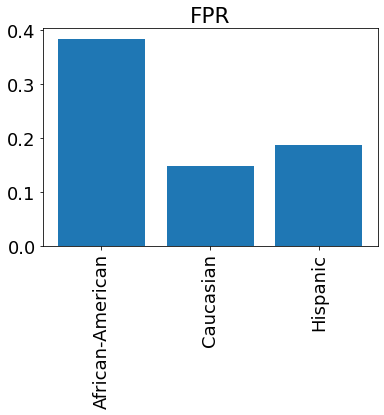

In [47]:
acc = accuracy_score(ytest, predictedNN)
precisionNN = precision_score(ytest, predictedNN)
recallNN = recall_score(ytest, predictedNN)
fmeasureNN = f1_score(ytest, predictedNN)
fprNN, tprNN, thresholdsGP = roc_curve(ytest, predictedNN)
rocNN = metrics.auc(fprNN, tprNN)
print("Accuracy: %0.4f" % acc)
print("Precision: %0.4f" % precisionNN)
print("Recall: %0.4f" % recallNN)
#print("F-mesure: %0.4f" % fmeasureAD)
#print("Surface sous la courbe ROC: %0.4f" % rocAD)
#skplt.metrics.plot_confusion_matrix(ytest, predictedNN, normalize=True)
#skplt.metrics.plot_roc(ytest, probasAD)
#skplt.metrics.plot_precision_recall(ytest, probasNN)
print_per_race(features_to_keep,predictedNN,X_plus_test,ytest)

Indeed, our classifiers all have similar accuracies to the COMPAS classifier ~60%. Furthermore, while the values of the rates are sometimes different, the trend is the same: African Americans have a lesser FNR and a higher FPR than Caucasians (and Hispanics). Interestingly, even though all of our classifiers have bias, it seems as though the Neural Network has the highest descrepencies between the rates. This is unexpected, as we predicted the MLP to be more powerful. 

It is possible that the flexibility of the neural network has made it overfit to the data in some way, and it is finding correlations that does not exist in reality, due to the unbalanced nature of the dataset. 

Anyway, greater steps have to be taken to attempt to ensure fairness. Before we do this, we will have a more detailed discussion on what fairness of a classifier truly entails. 

## Fairness

To establish a meaningful notion of fairness in this context, we must consider the implications of true/false positives/negatives. More specifically, getting false predictions can cause varying levels of harm depending on the problem at hand. For example, false negatives in cancer screenings are disasterous, as they incorrectly tell patients that they are free from a life-threatening illness. Alternatively, false positives, while perhaps being traumatic, are probably not as deadly.

In our case, false positives have very serious consequences: we are potentially giving harsher punishments to convicts due to an incorrect prediction of recidivism; the implication of this is the risk of creating a more "Orwellian" society. On the other hand, false negatives is giving a lighter punishment to someone who will end up recidivating; the implication of this is having an overly-lax society in which convicts are not concerned with the costs of reoffending. Obviously, the rates of these statistics are not mutually exclusive: both can be simultaneously low or high. However, stricter classifiers would most likely suffer from a high number of false positives, and more forgiving ones higher false negative rates.

Alas, a trade-off must be decided upon: do we want to ensure the safety of our populace by potentially infringing on the freedoms of convicts, or would we rather prioritize freedom and accept the risks of reoffending convicts slipping through the cracks? This is a more high-level definition of fairness that concerns itself with the applications of such a classifier *within society*.

However, there is a second, more critical notion of fairness that needs to be addressed: are certain demographics treated worse than others? We can refer to this fairness as _demographic fairness_. Certainly, this more low-level definition of fairness needs to be resolved before discussions can be had about the "general" fairness of a recidivism-predicting classifier.

For historical and socioeconomic reasons, simply maximizing the number of correctly-labeled convicts entails having certain bias. This is analogous to the well-known credit score example, wherein, similarly to the COMPAS classifier, minority demographics suffered from higher FNR and lower FPRs. Indeed, simply ignoring demographics as features (i.e. having the same threshold for every person) is not enough to recitify this bias - this was proved in the previous section. 

There have been formalizations of attaining demographic fairness for classifiers, where three laws are described: Independence, Separation, Sufficiency. 

Independence - or demographic parity - aims to have equal positive rates between demographics. For example, _affirmative action_ in universities or companies is an attempt to establish demographic parity, where the percentage of students/applicants who are accepted are equal between demographics like race and gender. Certainly, establishing independence risks creating a bias the opposite way, where - in our case - African Americans will have a higher FNR and a lower FPR than other races. Within universities and jobs, this is forgivable, as it can be seen as an attempt to balance the scales by providing more opporunities for underpriveledged demographics. However, the motivation behind the COMPAS dataset is _pragmatic_, and therefore such definition of demographic fairness seems out of place.

Separation - or predictive value parity - aims to have equal TPR and FPR between demographics. This definition is much more in line with our past evaluations of fairness, in which we looked at the FPR and FNR (which is complementary to the TPR) to judge whether the COMPASS and our classifiers were fair. 

Finally, sufficiency aims to make sure that the demographics and the prediction are independent from each other within scoring. Because we are unsure of how to guarantee it, we will not speak more on this law.

Therefore, to establish some level of demographic fairness, we will attempt to apply seperation within a classifier. 

## Implementing Separation

The most straight-forward way of implementing separation involves analyzing the ROC curves of different demographics and choosing between two options: reparameterizing the score function or having different thresholds for different demographics. Either way, our first step is thus to develop our own score function.

### Developing a Score Function

Developing a score function is not trivial, and constructing one from scratch is outside the scope of this class. However, we have thought of a workaround: we can train a logistic regression model to predict whether a convict will recidivate or not using our dataset. Furthermore, the Scikit-learn library provides a function which returns the probability estimates that a convict is placed into a certain class. This probability is analogous to the decile_score, which ranges from 1 to 10. By multiplying our probabilities and rounding them to the nearest digit, we can obtain a score for each convict. With this, we we effectively have our own score function. Below is the code:

In [48]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(Xtrain, ytrain.ravel())
pred = clf.predict(Xtest)

prob = clf.predict_proba(Xtest)
score = np.round(10 *clf.predict_proba(Xtest))
clf.score(Xtest, ytest)


0.63915857605178

The regression returns an accuracy of 65%, which is not great, but acceptable for our purposes. Out of curiosity, let us compare our scores to Equivant's:

In [49]:
counter = 0
mean = 0
for i in range(0, len(score)):
    mean += abs(score[i][1] - X_plus_test[i][9])
    counter+= 1
    #print(score[i][1], X_plus_test[i][9])
    
print("Average difference of : ", mean/counter)

Average difference of :  1.6148867313915858


This is a fairly low average difference.

Now, we can use these outputs to plot our ROC curves, by race. Although there have been signs of other biases, we will continue the rest of this report looking into African American vs Caucasian statistics, as they represent a large portion of the dataset and have been shown to have significant differences in their recidivism predictions.

Let us now plot the ROC curves:



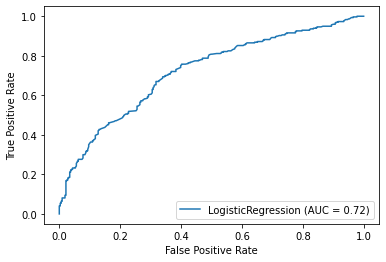

In [50]:
plt.rcParams.update({'font.size': 10})

#divide the data appropriately
ground_w = []
ground_b = []

prob_w = []
prob_b = []

TP_b = 0
FP_b = 0
TN_b = 0
FN_b = 0

TP_w = 0
FP_w = 0
TN_w = 0
FN_w = 0

le = encode_feature(ds,"race")

for i in range(0, len(prob)):
    race = X_plus_test[i][7]
    race = le.inverse_transform([race])
    v = (prob[i][1])
    g = X_plus_test[i][6]
    p = pred[i]
    if (race == 'African-American'):
        ground_b.append(g)
        prob_b.append(v)
        if (p == 1 and g == 1):
            TP_b += 1
        if (p == 1 and g == 0):
            FP_b += 1
        if (p == 0 and g == 0):
            TN_b += 1
        if (p == 0 and g == 1):
            FN_b += 1
   
    if (race == 'Caucasian'):
        prob_w.append(v)
        ground_w.append(g)
        
        if (p == 1 and g == 1):
            TP_w += 1
        if (p == 1 and g == 0):
            FP_w += 1
        if (p == 0 and g == 0):
            TN_w += 1
        if (p == 0 and g == 1):
            FN_w += 1




TPR_b = TP_b / (TP_b + FN_b)
FPR_b = FP_b / (FP_b + TN_b)

TPR_w = TP_w / (TP_w + FN_w)
FPR_w = FP_w / (FP_w + TN_w)

"""print(TPR_b / FPR_b)
print(TPR_w / FPR_w)
"""
metrics.plot_roc_curve(clf, Xtest, ytest)  
plt.show()

Notice here that the ROC curve is not very promising - it is quite close to f(x) = x.

Now that we have the data well-structured, we will look at ROC curves w.r.t race.

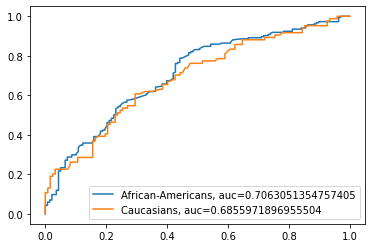

In [51]:
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

y_true = ground_b
y_probas = prob_b


plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_true,  y_probas)
auc = metrics.roc_auc_score(y_true, y_probas)
plt.plot(fpr,tpr,label="African-Americans, auc="+str(auc))


y_true = ground_w
y_probas = prob_w

fpr, tpr, _ = metrics.roc_curve(y_true,  y_probas)
auc = metrics.roc_auc_score(y_true, y_probas)
plt.plot(fpr,tpr,label="Caucasians, auc="+str(auc))

plt.legend(loc=0)

Strangely, we see ROC curves that are matching quite closely. With our bias, we would expect one curve to be much higher than the other. Out of curiosity, we look at the FPR and FNR by race:

In [52]:
print("FPR of African Americans : ", FP_b / (FP_b + TN_b))
print("FNR of African Americans : ", FN_b / (FN_b + TP_b))

print("FPR of Caucasians : \t", FP_w / (FP_b + TN_w))
print("FPR of Caucasians : \t", FN_w / (FN_b + TP_w))

FPR of African Americans :  0.38405797101449274
FNR of African Americans :  0.3532608695652174
FPR of Caucasians : 	 0.11464968152866242
FPR of Caucasians : 	 0.6741573033707865


While the regression has made it that African Americans have equal FPR and FNR, Caucasians have **significantly** different FPR and FNR. Based on the graph of the ROC curve, one might expect the rates to be relatively similar. However,this is far from the case. Unfortuately, we are unable to give a good reason as to why this is occurring. Our only hypothesis would be that the rates are somehow balancing each other out such that the ROC curves are relatvely similar. 

We would love to inspect this further, but we have unfortunately run short on time. 

# Conclusion

In conclusion, ensuring fairness within a classifier is extremely difficult for a multitude of reasons: data, type of classifier, intrinsic bias within a society, etc. Although we felt we were on the right path, and were very happy with our relatively accurate score function, we were unable to create a unbiased classifier. Ultimately, it was a very gratifying project that allowed us to gain a greater understanding of data science in general. 